In [ ]:
import os, config
import pandas as pd
import numpy as np
import torch
from torch_geometric.data import Data

c:\Users\pegoo\anaconda3\envs\graph_env\Lib\site-packages\torch_geometric\__init__.py:4: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: Could not load this library: C:\Users\pegoo\anaconda3\envs\graph_env\Lib\site-packages\libpyg.pyd
  import torch_geometric.typing
c:\Users\pegoo\anaconda3\envs\graph_env\Lib\site-packages\torch_geometric\__init__.py:4: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: Could not load this library: C:\Users\pegoo\anaconda3\envs\graph_env\Lib\site-packages\torch_scatter\_version_cuda.pyd
  import torch_geometric.typing
c:\Users\pegoo\anaconda3\envs\graph_env\Lib\site-packages\torch_geometric\__init__.py:4: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: Could not load this library: C:\Users\pegoo\anaconda3\envs\graph_env\Lib\site-packages\torch_cluster\_version_cuda.pyd
  import torch_geometric.typing
c:\Users\pegoo\a

In [ ]:
tt_path = os.path.join(config.DATA_DIR, 'Transcription_Topic')

sample_df = pd.read_csv(os.path.join(config.DATA_DIR, 'Transcription_Topic', os.listdir(tt_path)[0]))

In [ ]:
sample_df.tail(10)

,start_time,stop_time,speaker,value,topic
164,589.148,590.918,Ellie,how would your best friend describe you,개인 특성 및 경험
165,598.238,599.708,Participant,chocolate,NaN
166,600.608,601.378,Participant,tall,NaN
167,601.718,602.688,Ellie,[laughter],NaN
168,602.738,603.478,Participant,thin,NaN
169,610.398,611.098,Ellie,okay,NaN
170,614.228,616.878,Ellie,okay i think i've asked everything i need to,NaN
171,618.308,619.078,Participant,thank you,NaN
172,619.488,620.348,Ellie,goodbye,NaN
173,620.538,621.268,Participant,bye bye,NaN


In [ ]:
len(sample_df[sample_df.speaker=='Participant'])

87

In [ ]:
finish_utterance = ["asked everything", "asked_everything"]

sample_participant_dict = {}

current_topic = None
temp = ""

for idx, row in sample_df.iterrows():
  if row['speaker'] == 'Ellie':
    if current_topic is not None and temp != "":  
      if not current_topic in sample_participant_dict.keys():
        sample_participant_dict[current_topic] = []
      sample_participant_dict[current_topic].append(temp.strip())
      temp = ""
    if not pd.isna(row['topic']):
      current_topic = row['topic']
    if (finish_utterance[0] in row['value'] or finish_utterance[1] in row['value']):
      current_topic = None
  if row['speaker'] == 'Participant':
    temp += row['value'] + ". "

In [ ]:
sample_participant_dict

{'생활 환경 및 취미': ['good. atlanta georgia.',
  'um my parents are from here um.',
  'i love it.',
  'i like the weather. i like the opportunities. um. yes.',
  'um. it took a minute. somewhat easy.',
  'congestion.',
  "that's it.",
  'no.',
  "um no specific reason i just. don't travel a lot. i'm pretty local.",
  'once a year.',
  'i like to play sports i enjoy uh going out with friends and family. playing games.',
  'living with who.',
  "um it's alright it could be better.",
  'not. no.',
  "uh it's pretty easy."],
 '경력, 교육 및 군 복무': ['um i took up business and administration.',
  "uh yeah i am. here and there i'm on a break right now but i plan on going back in the uh next semester.",
  'uh probably to open up my own business.',
  'uh taking a job off the street.',
  "i'm sure i could've yes.",
  'no.'],
 '개인 특성 및 경험': ['can you be a little bit more specific.',
  'no answer.',
  'i like reading books i enjoy i enjoy cooking. um exercising is great.',
  "i'm not sure. maybe when i grad

In [ ]:
from sentence_transformers import SentenceTransformer
sentences = "This is an example sentence"

model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
embeddings = model.encode(sentences)
print(len(embeddings))

384


In [ ]:
a = np.array([[1],[3]])
b = np.array([[2],[4]])
c = np.array([[1]])
np.concatenate([np.concatenate([a,b]),c])

array([[1],
       [3],
       [2],
       [4],
       [1]])

In [ ]:
a = np.array([[1,2]])
b = np.array([[3,4]])
np.average(np.concatenate([a,b]),axis=0)

array([2., 3.])

In [ ]:
# 0번은 summary node
# 1번부터 topic node를 채워가기
# 이후 모두 concat

s_k_num = len(sample_participant_dict.keys())+1
source_nodes = np.arange(1,s_k_num)
target_nodes = np.zeros_like(source_nodes)
k_nodes = None
v_nodes = None
s_node = None

for idx, (k, v) in enumerate(sample_participant_dict.items()):
  if v_nodes is None:
    start_index = s_k_num
  else:
    start_index = s_k_num + len(v_nodes)

  k_embed = model.encode([k])
  if k_nodes is None:
    k_nodes = k_embed
  else:
    k_nodes = np.concatenate([k_nodes, k_embed])

  nodes = None
  for t in v:
    t_embed = model.encode([t])
    if nodes is None:
      nodes = t_embed
    else:
      nodes = np.concatenate([nodes, t_embed])
  
  if nodes is None:
    print("No Nodes")
    continue
  
  if v_nodes is None:
    v_nodes = nodes
  else:
    v_nodes = np.concatenate([v_nodes, nodes])

  temp_source_nodes = np.arange(start_index, start_index+len(nodes))
  temp_target_nodes = np.full((len(nodes),), idx+1)

  source_nodes = np.concatenate([source_nodes,temp_source_nodes])
  target_nodes = np.concatenate([target_nodes,temp_target_nodes])

if k_nodes is not None:
  s_node = np.average(k_nodes, axis=0).reshape(1, -1)
else:
  print("No Topic Nodes")
  s_node = np.array([[]])

print("Summary Node Shape:", s_node.shape)
print("Topic Node Shape:", k_nodes.shape)
print("Utterance Node Shape:", v_nodes.shape)
print("Source Node Shape:", source_nodes.shape)
print("Target Node Shape:", target_nodes.shape)

Summary Node Shape: (1, 384)
Topic Node Shape: (5, 384)
Utterance Node Shape: (55, 384)
Source Node Shape: (60,)
Target Node Shape: (60,)


In [ ]:
source_nodes

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60])

In [ ]:
target_nodes

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5])

In [ ]:
total_nodes = np.concatenate([s_node, k_nodes, v_nodes])
x = torch.tensor(total_nodes, dtype=torch.float)
edge_index = torch.tensor([source_nodes, target_nodes], dtype=torch.long)

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_11292\2703730652.py:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:256.)
  edge_index = torch.tensor([source_nodes, target_nodes], dtype=torch.long)


In [ ]:
# Data 객체 생성
data = Data(x=x, edge_index=edge_index)

print("--- PyTorch Geometric Data 객체 생성 완료 ---")
print(data)
print(f"노드 수: {data.num_nodes}")    # 3
print(f"엣지 수: {data.num_edges}")    # 4 (단방향 엣지 4개)
print(f"특징 차원: {data.num_node_features}") # 4
print(f"양방향 엣지 여부: {data.is_undirected()}") # False (단방향 엣지가 포함되어 있으므로)

--- PyTorch Geometric Data 객체 생성 완료 ---
Data(x=[61, 384], edge_index=[2, 60])
노드 수: 61
엣지 수: 60
특징 차원: 384
양방향 엣지 여부: False


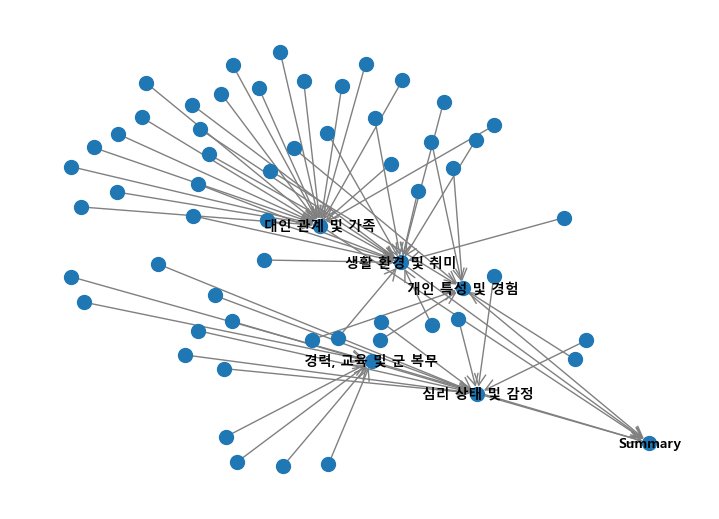

In [ ]:
import torch
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx

plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

G = to_networkx(data, to_undirected=False)

# 3. 노드 ID(0, 1, 2)에 레이블(A, B, C) 지정
node_labels = {i+1:k
               for i, k in enumerate(sample_participant_dict.keys())}
node_labels[0] = 'Summary'

# 4. 그래프 시각화
plt.figure(figsize=(7, 5))
pos = nx.spring_layout(G) # 노드 위치 결정 알고리즘 (레이아웃)

nx.draw(G, pos,
        with_labels=True,
        labels=node_labels, # A, B, C 레이블 사용
        node_size=100, 
        font_size=10,
        font_weight='bold',
        edge_color='gray',
        arrows=True, # 화살표 표시 (방향성)
        arrowstyle='->',
        arrowsize=20,
        font_family='Malgun Gothic'
       )

## 전체 실행 코드

In [46]:
import os, config
import pandas as pd
import numpy as np
import torch
from torch_geometric.data import Data
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

tt_path = os.path.join(config.DATA_DIR, 'Transcription_Topic')

dataframes = []

for file in os.listdir(tt_path)[0]:
  pd.read_csv(os.path.join(config.DATA_DIR, 'Transcription_Topic', os.listdir(tt_path)[0]))

In [54]:
from tqdm import tqdm
def make_graph(ids, labels, model_name):
  finish_utterance = ["asked everything", "asked_everything"]

  print("Getting your model")
  model = SentenceTransformer(model_name)
  print("Model loaded")
  dataframes = []
  print("Switching CSV into Graphs")

  for id in ids:
    df = pd.read_csv(os.path.join(config.DATA_DIR, 'Transcription_Topic', f"{id}_transcript_topic.csv"))
    dataframes.append(df)

  graphs = []
  dict_list = []
  
  for graph_idx, df in tqdm(enumerate(dataframes), desc="Dataframe->Graph", total=len(dataframes)):
    participant_dict = {
      t : []
      for t in df.topic.unique() if type(t)==str
    }
    start_stop_dict = {}

    df.topic = df.topic.ffill()
    df = df.reset_index()
    search_pattern = '|'.join(finish_utterance)
    condition = df['value'].str.contains(search_pattern, na=False)
    terminate_index = df.index[condition]
    df = df.iloc[:terminate_index.values[0]]
    participant_df = df[df.speaker=='Participant']

    previous_index = None
    previous_topic = None
    temp = ""
    start_time = 0
    stop_time = 0

    for idx, row in participant_df.iterrows():
      value = row['value']
      if pd.isna(value):
        value_str = ""
      else:
        value_str = str(value)

      # 연속 여부 판단
      if previous_index == row['index']-1 and previous_topic==row.topic:
        temp += value_str + ". "
        stop_time = row.stop_time
      else:
        if temp!="" and not pd.isna(previous_topic):
          participant_dict[previous_topic].append(temp)
          start_stop_dict[temp] = [start_time, stop_time]
        previous_topic = row.topic
        temp = value_str
        start_time = row.start_time
        stop_time = row.stop_time

      previous_index = row['index']

    # 마지막 값 저장
    if temp!="" and not pd.isna(previous_topic):
      participant_dict[previous_topic].append(temp)
      start_stop_dict[temp] = [start_time, stop_time]

    s_k_num = len(participant_dict.keys())+1
    source_nodes = np.arange(1, s_k_num)
    target_nodes = np.full(source_nodes.shape, 0)
    topic_nodes = model.encode(list(participant_dict.keys()))
    extra_nodes = None

    for idx, v in enumerate(participant_dict.values()):
      if extra_nodes is None:
        start_index = s_k_num
      else:
        start_index = s_k_num + len(extra_nodes)

      v_embed = model.encode(v)
      num_utterances = len(v_embed)
      if extra_nodes is None:
        extra_nodes = v_embed
      else:
        extra_nodes = np.concatenate([extra_nodes, v_embed])

      temp_source_nodes = np.arange(start_index, start_index+num_utterances)
      temp_target_nodes = np.full((num_utterances,), idx+1)

      if num_utterances > 1:
        t_forward_src = temp_source_nodes[:-1]
        t_forward_tgt = temp_source_nodes[1:]
        t_backward_src = temp_source_nodes[1:]
        t_backward_tgt = temp_source_nodes[:-1]
      else:
        t_forward_src = t_forward_tgt = t_backward_src = t_backward_tgt = np.array([], dtype=int)

      source_nodes = np.concatenate([source_nodes,temp_source_nodes, t_forward_src, t_backward_src])
      target_nodes = np.concatenate([target_nodes,temp_target_nodes, t_forward_tgt, t_backward_tgt])
      
    s_node = np.average(topic_nodes, axis=0).reshape(1, -1)

    if extra_nodes is None:
      print(f"#{idx} data has empty nodes -> continue to next")
      continue
    else:
      total_nodes = np.concatenate([s_node, topic_nodes, extra_nodes])
    x = torch.tensor(total_nodes, dtype=torch.float)
    edge_index = torch.tensor([source_nodes, target_nodes], dtype=torch.long)
    y = torch.tensor([labels[graph_idx]], dtype=torch.long)
    data = Data(x=x, edge_index=edge_index, y=y)
    graphs.append(data)
    dict_list.append(participant_dict)
  return graphs, dict_list

In [55]:
graph_list, dict_list = make_graph([300], [0], 'sentence-transformers/all-MiniLM-L6-v2')

Getting your model
Model loaded
Switching CSV into Graphs


Dataframe->Graph: 100%|██████████| 1/1 [00:00<00:00, 15.37it/s]


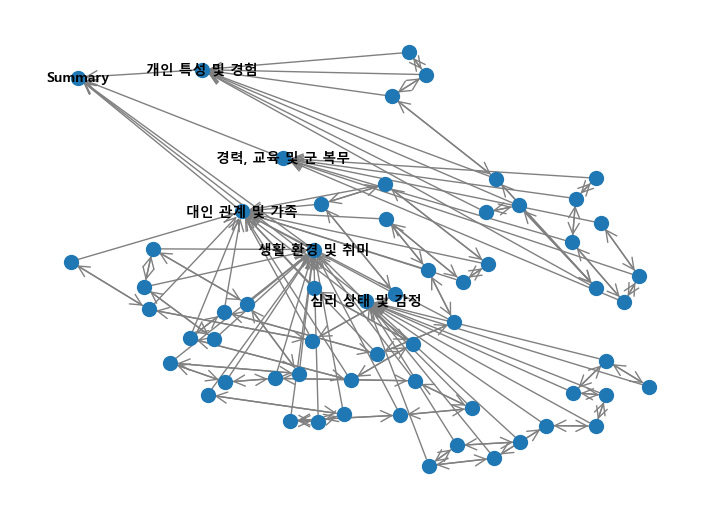

In [57]:
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

G = to_networkx(graph_list[0], to_undirected=False)

# 3. 노드 ID(0, 1, 2)에 레이블(A, B, C) 지정
node_labels = {i+1:k
               for i, k in enumerate(dict_list[0].keys())}
node_labels[0] = 'Summary'

# 4. 그래프 시각화
plt.figure(figsize=(7, 5))
pos = nx.spring_layout(G) # 노드 위치 결정 알고리즘 (레이아웃)

nx.draw(G, pos,
        with_labels=True,
        labels=node_labels, # A, B, C 레이블 사용
        node_size=100, 
        font_size=10,
        font_weight='bold',
        edge_color='gray',
        arrows=True, # 화살표 표시 (방향성)
        arrowstyle='->',
        arrowsize=20,
        font_family='Malgun Gothic'
       )

In [ ]:
train_df = pd.read_csv(os.path.join(config.DATA_DIR, 'train_split_Depression_AVEC2017.csv'))

train_id = train_df.Participant_ID.tolist()
train_label = train_df.PHQ8_Binary.tolist()
make_graph(train_id, train_label, 'sentence-transformers/all-MiniLM-L6-v2')

Getting your model
Model loaded
Switching CSV into Graphs


Dataframe->Graph: 100%|██████████| 107/107 [00:05<00:00, 18.24it/s]


[Data(x=[60, 384], edge_index=[2, 59], y=[1]),
 Data(x=[77, 384], edge_index=[2, 76], y=[1]),
 Data(x=[91, 384], edge_index=[2, 90], y=[1]),
 Data(x=[77, 384], edge_index=[2, 76], y=[1]),
 Data(x=[65, 384], edge_index=[2, 64], y=[1]),
 Data(x=[54, 384], edge_index=[2, 53], y=[1]),
 Data(x=[61, 384], edge_index=[2, 60], y=[1]),
 Data(x=[76, 384], edge_index=[2, 75], y=[1]),
 Data(x=[63, 384], edge_index=[2, 62], y=[1]),
 Data(x=[43, 384], edge_index=[2, 42], y=[1]),
 Data(x=[58, 384], edge_index=[2, 57], y=[1]),
 Data(x=[100, 384], edge_index=[2, 99], y=[1]),
 Data(x=[84, 384], edge_index=[2, 83], y=[1]),
 Data(x=[67, 384], edge_index=[2, 66], y=[1]),
 Data(x=[75, 384], edge_index=[2, 74], y=[1]),
 Data(x=[47, 384], edge_index=[2, 46], y=[1]),
 Data(x=[72, 384], edge_index=[2, 71], y=[1]),
 Data(x=[64, 384], edge_index=[2, 63], y=[1]),
 Data(x=[66, 384], edge_index=[2, 65], y=[1]),
 Data(x=[58, 384], edge_index=[2, 57], y=[1]),
 Data(x=[59, 384], edge_index=[2, 58], y=[1]),
 Data(x=[71,

## 전체 실행 코드 보완

In [20]:
import os, config as path_config, sys
import pandas as pd
import numpy as np
import torch
from tqdm import tqdm
from torch_geometric.data import Data
from sentence_transformers import SentenceTransformer
from loguru import logger

logger.remove()
logger.add(
  sys.stdout,
  colorize=True,
  format="<green>{time:HH:mm:ss}</green> | <level>{level: <8}</level> | <level>{message}</level>",
)

model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

In [21]:
def process_vision(df):
  timestamp = df.timestamp
  au_r = df.filter(like='au').filter(like='_r')
  gz_df = df.filter(like='gz')
  gz_h = gz_df.filter(like='h')
  ps_t = df.filter(like='ps').filter(like='T')
  ps_r = df.filter(like='ps').filter(like='R')
  vision = pd.concat([timestamp, au_r, gz_h, ps_t, ps_r], axis=1)
  return vision

def make_graph(ids, labels, model_name):
  try:
    finish_utterance = ["asked everything", "asked_everything", "it was great chatting with you"]

    logger.info("Getting your model")
    model = SentenceTransformer(model_name)
    logger.info("Model loaded")
    dataframes = []
    logger.info("Reading CSV")

    for id in tqdm(ids, desc="Loading Dataframes"):
      df = pd.read_csv(os.path.join(path_config.DATA_DIR, 'Transcription_Topic', f"{id}_transcript_topic.csv"))
      v_df = pd.read_csv(os.path.join(path_config.DATA_DIR, 'Vision Summary', f"{id}_vision_summary.csv"))
      a_df = pd.read_csv(os.path.join(path_config.DATA_DIR, 'Audio Summary', f"{id}_audio_summary.csv"))
      dataframes.append((df, v_df, a_df))
    
    logger.info("Switching CSV into Graphs")
    graphs = []
    dict_list = []
    
    for graph_idx, (df, v_df, a_df) in tqdm(enumerate(dataframes), desc="Dataframe -> Graph", total=len(dataframes)):
      try:
        participant_dict = {
          t : []
          for t in df.topic.unique() if type(t)==str
        }
        start_stop_dict = {}

        df.topic = df.topic.ffill()
        df = df.reset_index()
        search_pattern = '|'.join(finish_utterance)
        condition = df['value'].str.contains(search_pattern, na=False)
        terminate_index = df.index[condition]
        df = df.iloc[:terminate_index.values[0]]
        participant_df = df[df.speaker=='Participant']

        vision = process_vision(v_df)

        previous_index = None
        previous_topic = None
        temp = ""
        start_time = 0
        stop_time = 0

        for idx, row in participant_df.iterrows():
          value = row['value']
          if pd.isna(value):
            value_str = ""
          else:
            value_str = str(value)

          # 연속 여부 판단
          if previous_index == row['index']-1 and previous_topic==row.topic:
            temp += value_str + ". "
            stop_time = row.stop_time
          else:
            if temp!="" and not pd.isna(previous_topic):
              participant_dict[previous_topic].append(temp)
              start_stop_dict[temp] = [start_time, stop_time]
            previous_topic = row.topic
            temp = value_str
            start_time = row.start_time
            stop_time = row.stop_time

          previous_index = row['index']

        # 마지막 값 저장
        if temp!="" and not pd.isna(previous_topic):
          participant_dict[previous_topic].append(temp)
          start_stop_dict[temp] = [start_time, stop_time]

        # 노드 정의
        s_k_num = len(participant_dict.keys())+1
        source_nodes = np.arange(1, s_k_num)
        target_nodes = np.full(source_nodes.shape, 0)
        topic_nodes = model.encode(list(participant_dict.keys()))
        extra_nodes = None

        node_types = []
        node_types.append('summary')  # 0번 노드
        node_types.extend(['topic'] * len(topic_nodes))  # topic 노드들

        global vision_dim
        global audio_dim
        vision_dim = len(vision.columns)-1 # timestamp 컬럼 제외
        audio_dim = len(a_df.columns)

        vision_pad_dim = topic_nodes.shape[1] - vision_dim
        audio_pad_dim = topic_nodes.shape[1] - len(a_df.columns)

        vision_pad_width = [(0,vision_pad_dim)]
        audio_pad_width = [(0,audio_pad_dim)]

        for idx, v in enumerate(participant_dict.values()):
          vision_audio_nodes = []
          vision_audio_target = []

          if extra_nodes is None:
            start_index = s_k_num
          else:
            start_index = s_k_num + len(extra_nodes)

          transcription_embed = model.encode(v)

          # transcription, vision, audio 모두 생성
          temp_source_nodes = np.arange(start_index, start_index+(len(transcription_embed)*3))
          # transcription만 생성
          temp_target_nodes = np.full((len(transcription_embed),), idx+1)

          for idx, t in enumerate(v):
            
            start, stop = start_stop_dict[t]
            v_target = vision.loc[(start <= vision.timestamp) & (vision.timestamp <= stop)]
            v_target = v_target.drop(columns=['timestamp'])
            mean_v_target = v_target.mean().tolist()
            padded_v = np.pad(mean_v_target, pad_width=vision_pad_width, mode='constant', constant_values=0)
            vision_audio_nodes.append(padded_v)  # 각 특성의 평균
            a_target = a_df.iloc[int(start*100):int((stop*100)+1)]
            mean_a_target = a_target.mean().tolist()
            padded_a = np.pad(mean_a_target, pad_width=audio_pad_width, mode='constant', constant_values=0)
            vision_audio_nodes.append(padded_a)
            vision_audio_target.extend([start_index+idx, start_index+idx])

          vision_audio_stack=np.stack(vision_audio_nodes)
          vision_audio_target_np = np.array(vision_audio_target)

          if extra_nodes is None:
            extra_nodes = np.concatenate([transcription_embed, vision_audio_stack])
          else:
            extra_nodes = np.concatenate([extra_nodes, transcription_embed, vision_audio_stack])

          node_types.extend(['transcription'] * len(transcription_embed))
          node_types.extend(['vision', 'audio'] * (len(transcription_embed)))

          source_nodes = np.concatenate([source_nodes,temp_source_nodes])
          target_nodes = np.concatenate([target_nodes,temp_target_nodes,vision_audio_target_np])

        summary_node = np.average(topic_nodes, axis=0).reshape(1, -1)

        if extra_nodes is None:
          logger.error(f"#{idx} data has empty nodes -> continue to next")
          continue
        else:
          total_nodes = np.concatenate([summary_node, topic_nodes, extra_nodes])

        x = torch.tensor(total_nodes, dtype=torch.float)
        edge_index = torch.tensor([source_nodes, target_nodes], dtype=torch.long)
        y = torch.tensor([labels[graph_idx]], dtype=torch.long)
        data = Data(x=x, edge_index=edge_index, y=y, node_types=node_types)
        graphs.append(data)
        dict_list.append(participant_dict)
      except Exception as e:
        logger.error(f"Index:{graph_idx}: {e}")
    return graphs, dict_list, vision_dim, audio_dim
  except Exception as e:
    logger.error(e)

In [22]:
graph_list, dict_list, _, _ = make_graph([300], [0], 'sentence-transformers/all-MiniLM-L6-v2')

18:28:17 | INFO     | Getting your model
18:28:20 | INFO     | Model loaded
18:28:20 | INFO     | Reading CSV


Loading Dataframes: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]

18:28:21 | INFO     | Switching CSV into Graphs



Dataframe -> Graph: 100%|██████████| 1/1 [00:00<00:00, 10.58it/s]


In [23]:
graph_list[0].x.shape[1]

384

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_19100\3625529926.py:58: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


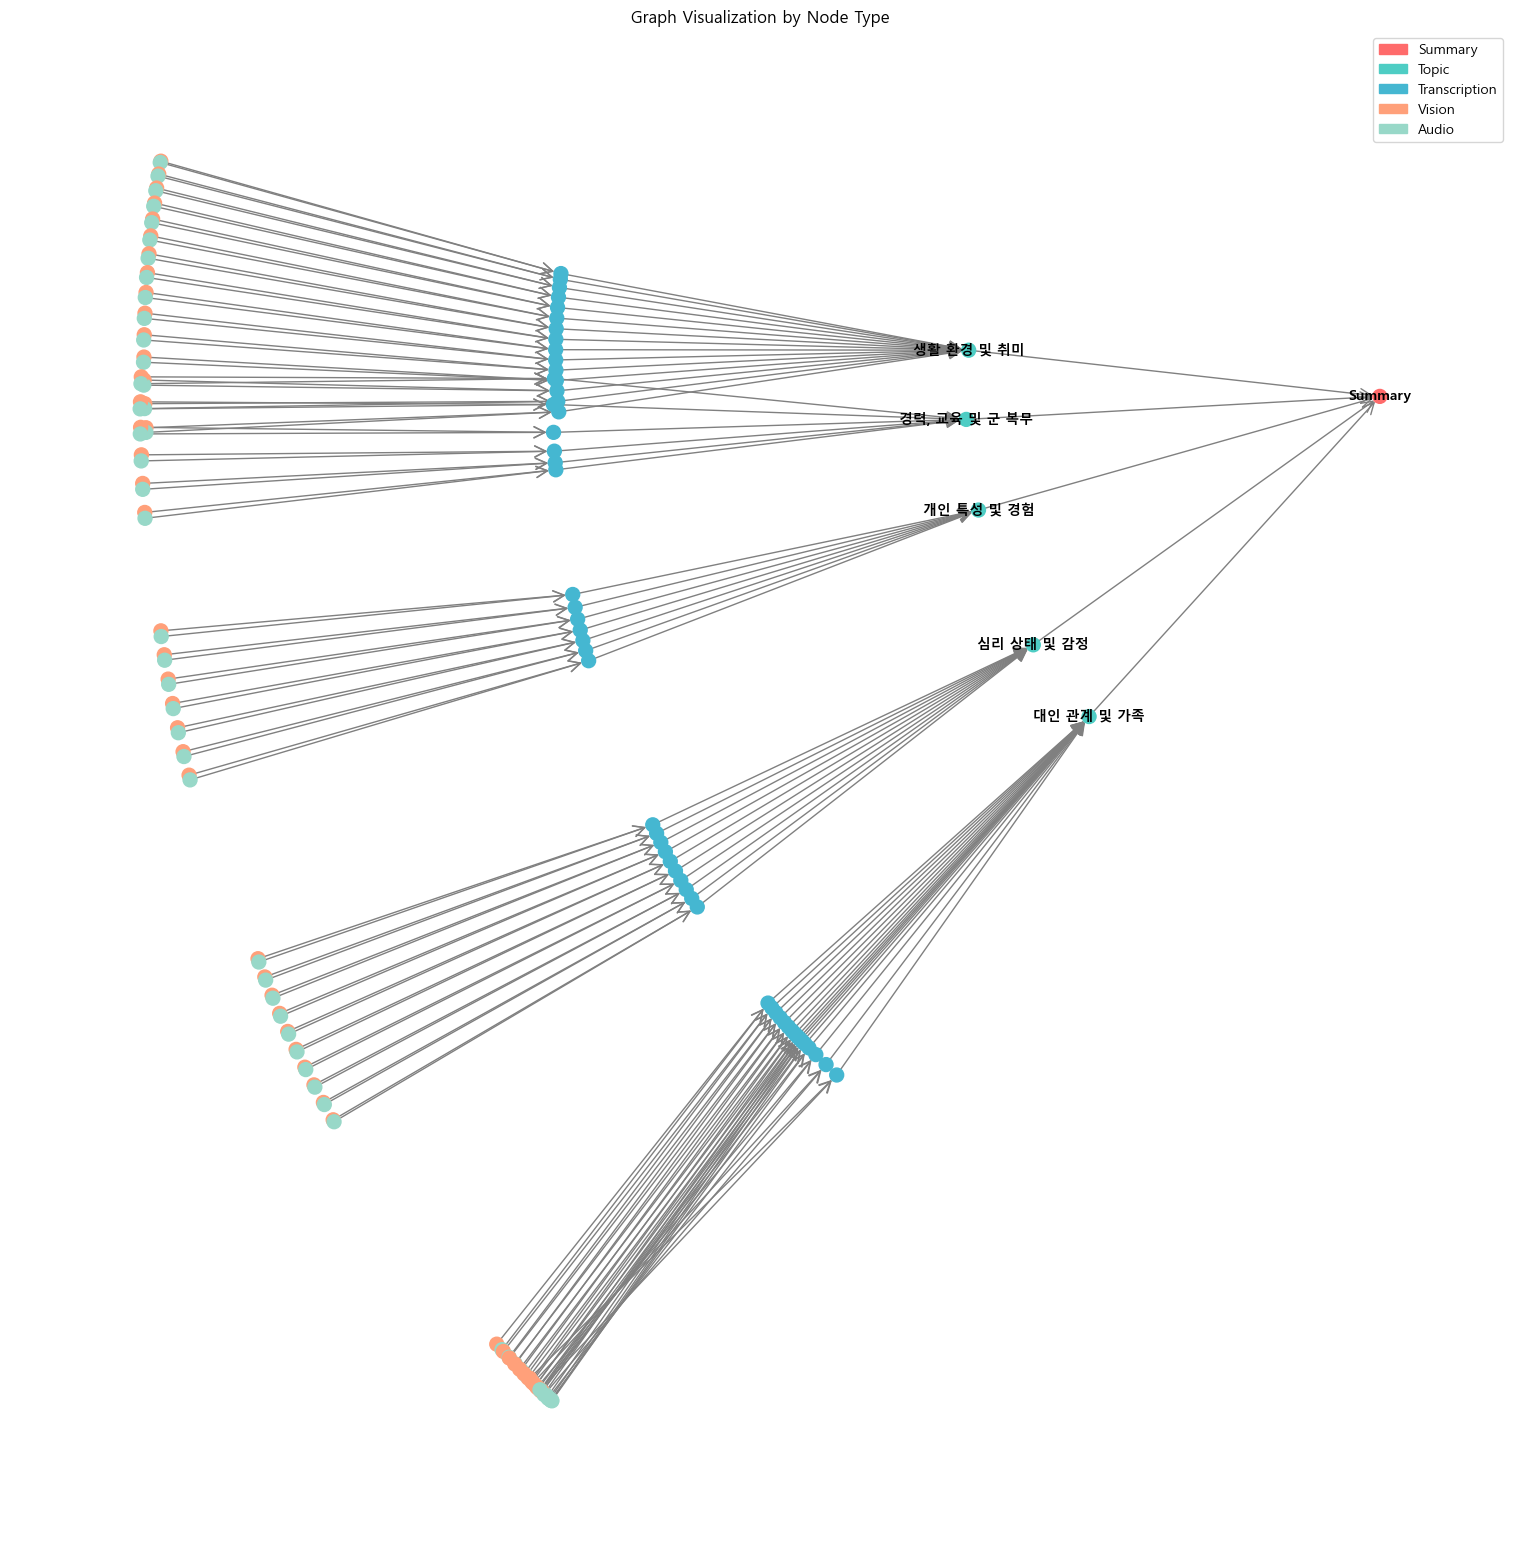

In [28]:
import torch
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx
import matplotlib.patches as mpatches

plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

color_map = {
    'summary': '#FF6B6B',      # 빨강
    'topic': '#4ECDC4',        # 청록
    'transcription': '#45B7D1', # 파랑
    'vision': '#FFA07A',       # 주황
    'audio': '#98D8C8'         # 민트
}

node_colors = [color_map.get(node_type, 'gray') for node_type in graph_list[0].node_types]

G = to_networkx(graph_list[0], to_undirected=False)

# 3. 노드 ID(0, 1, 2)에 레이블(A, B, C) 지정
node_labels = {i+1:k
               for i, k in enumerate(dict_list[0].keys())}
node_labels[0] = 'Summary'

# 4. 그래프 시각화
plt.figure(figsize=(15, 15))
pos = nx.kamada_kawai_layout(G) # 노드 위치 결정 알고리즘 (레이아웃)

nx.draw(G, pos,
        with_labels=True,
        labels=node_labels, # A, B, C 레이블 사용
        node_color=node_colors,
        node_size=100, 
        font_size=10,
        font_weight='bold',
        edge_color='gray',
        arrows=True, # 화살표 표시 (방향성)
        arrowstyle='->',
        arrowsize=20,
        font_family='Malgun Gothic',
        
       )

legend_elements = [
    mpatches.Patch(color=color_map['summary'], label='Summary'),
    mpatches.Patch(color=color_map['topic'], label='Topic'),
    mpatches.Patch(color=color_map['transcription'], label='Transcription'),
    mpatches.Patch(color=color_map['vision'], label='Vision'),
    mpatches.Patch(color=color_map['audio'], label='Audio')
]
plt.legend(handles=legend_elements, loc='upper right')

plt.title("Graph Visualization by Node Type")
plt.axis('off')
plt.tight_layout()
plt.show()

## 패딩 없는 버전

In [1]:
import os, config as path_config, sys
import pandas as pd
import numpy as np
import torch
from tqdm import tqdm
from torch_geometric.data import Data
from sentence_transformers import SentenceTransformer
from loguru import logger

logger.remove()
logger.add(
  sys.stdout,
  colorize=True,
  format="<green>{time:HH:mm:ss}</green> | <level>{level: <8}</level> | <level>{message}</level>",
)

model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

c:\Users\pegoo\anaconda3\envs\graph_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
def process_vision(df):
  timestamp = df.timestamp
  au_r = df.filter(like='au').filter(like='_r')
  gz_df = df.filter(like='gz')
  gz_h = gz_df.filter(like='h')
  ps_t = df.filter(like='ps').filter(like='T')
  ps_r = df.filter(like='ps').filter(like='R')
  vision = pd.concat([timestamp, au_r, gz_h, ps_t, ps_r], axis=1)
  return vision

def make_graph_2(ids, labels, model_name):
  try:
    finish_utterance = ["asked everything", "asked_everything", "it was great chatting with you"]

    logger.info("Getting your model")
    model = SentenceTransformer(model_name)
    logger.info("Model loaded")
    dataframes = []
    logger.info("Reading CSV")

    for id in tqdm(ids, desc="Loading Dataframes"):
      df = pd.read_csv(os.path.join(path_config.DATA_DIR, 'Transcription_Topic', f"{id}_transcript_topic.csv"))
      v_df = pd.read_csv(os.path.join(path_config.DATA_DIR, 'Vision Summary', f"{id}_vision_summary.csv"))
      a_df = pd.read_csv(os.path.join(path_config.DATA_DIR, 'Audio Summary', f"{id}_audio_summary.csv"))
      dataframes.append((df, v_df, a_df))
    
    logger.info("Switching CSV into Graphs")
    graphs = []
    dict_list = []
    
    for graph_idx, (df, v_df, a_df) in tqdm(enumerate(dataframes), desc="Dataframe -> Graph", total=len(dataframes)):
      try:
        participant_dict = {
          t : []
          for t in df.topic.unique() if type(t)==str
        }
        start_stop_dict = {}

        df.topic = df.topic.ffill()
        df = df.reset_index()
        search_pattern = '|'.join(finish_utterance)
        condition = df['value'].str.contains(search_pattern, na=False)
        terminate_index = df.index[condition]
        df = df.iloc[:terminate_index.values[0]]
        participant_df = df[df.speaker=='Participant']

        vision = process_vision(v_df)

        previous_index = None
        previous_topic = None
        temp = ""
        start_time = 0
        stop_time = 0

        for idx, row in participant_df.iterrows():
          value = row['value']
          if pd.isna(value):
            value_str = ""
          else:
            value_str = str(value)

          # 연속 여부 판단
          if previous_index == row['index']-1 and previous_topic==row.topic:
            temp += value_str + ". "
            stop_time = row.stop_time
          else:
            if temp!="" and not pd.isna(previous_topic):
              participant_dict[previous_topic].append(temp)
              start_stop_dict[temp] = [start_time, stop_time]
            previous_topic = row.topic
            temp = value_str
            start_time = row.start_time
            stop_time = row.stop_time

          previous_index = row['index']

        # 마지막 값 저장
        if temp!="" and not pd.isna(previous_topic):
          participant_dict[previous_topic].append(temp)
          start_stop_dict[temp] = [start_time, stop_time]

        # 노드 정의
        s_k_num = len(participant_dict.keys())+1
        source_nodes = np.arange(1, s_k_num)
        target_nodes = np.full(source_nodes.shape, 0)
        topic_nodes = model.encode(list(participant_dict.keys()))
        extra_nodes = []
        total_nodes = []

        # 노드 타입 정의
        node_types = []
        node_types.append('summary')  # 0번 노드
        node_types.extend(['topic'] * len(topic_nodes))  # topic 노드들

        for idx, v in enumerate(participant_dict.values()):
          vision_nodes = []
          audio_nodes = []
          vision_target = []
          audio_target = []

          if extra_nodes == []:
            start_index = s_k_num
          else:
            start_index = s_k_num + len(extra_nodes)

          transcription_embed = model.encode(v)

          # transcription, vision, audio 모두 생성
          temp_source_nodes = np.arange(start_index, start_index+(len(transcription_embed)*3))
          # transcription만 생성
          temp_target_nodes = np.full((len(transcription_embed),), idx+1)

          for idx, t in enumerate(v):
            
            start, stop = start_stop_dict[t]
            v_target = vision.loc[(start <= vision.timestamp) & (vision.timestamp <= stop)]
            v_target = v_target.drop(columns=['timestamp'])
            mean_v_target = v_target.mean().tolist()
            vision_nodes.append(mean_v_target)  # 각 특성의 평균
            a_target = a_df.iloc[int(start*100):int((stop*100)+1)]
            mean_a_target = a_target.mean().tolist()
            audio_nodes.append(mean_a_target)
            vision_target.append(start_index+idx)
            audio_target.append(start_index+idx)

          vision_target_np = np.array(vision_target)
          audio_target_np = np.array(audio_target)

          extra_nodes.extend(transcription_embed.tolist())
          extra_nodes.extend(vision_nodes)
          extra_nodes.extend(audio_nodes)

          source_nodes = np.concatenate([source_nodes,temp_source_nodes])
          target_nodes = np.concatenate([target_nodes,temp_target_nodes,vision_target_np,audio_target_np])

          node_types.extend(['transcription'] * len(transcription_embed))
          node_types.extend(['vision'] * (len(vision_nodes)))
          node_types.extend(['audio'] * (len(audio_nodes)))

        summary_node = np.average(topic_nodes, axis=0).reshape(1, -1)

        if extra_nodes == []:
          logger.error(f"#{idx} data has empty nodes -> continue to next")
          continue
        else:
          total_nodes.extend(summary_node)
          total_nodes.extend(topic_nodes)
          total_nodes.extend(extra_nodes)

        x = [torch.tensor(node, dtype=torch.float) for node in total_nodes]
        edge_index = torch.tensor([source_nodes, target_nodes], dtype=torch.long)
        y = torch.tensor([labels[graph_idx]], dtype=torch.long)
        data = Data(x=x, edge_index=edge_index, y=y, node_types=node_types)
        graphs.append(data)
        dict_list.append(participant_dict)
      except Exception as e:
        logger.error(f"Index:{graph_idx}: {e}")
    return graphs, dict_list
  except Exception as e:
    logger.error(e)


In [9]:
graph_list, dict_list = make_graph_2([300], [0], 'sentence-transformers/all-MiniLM-L6-v2')

17:07:19 | INFO     | Getting your model
17:07:21 | INFO     | Model loaded
17:07:21 | INFO     | Reading CSV


Loading Dataframes: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]

17:07:22 | INFO     | Switching CSV into Graphs



Dataframe -> Graph: 100%|██████████| 1/1 [00:00<00:00,  5.79it/s]


In [10]:
graph_list

[Data(x=[171], edge_index=[2, 170], y=[1], node_types=[171])]

c:\Users\pegoo\anaconda3\envs\graph_env\lib\site-packages\torch_geometric\data\data.py:228: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'y', 'node_types', 'x', 'edge_index'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  offset = offset + store.num_nodes
c:\Users\pegoo\anaconda3\envs\graph_env\lib\site-packages\torch_geometric\utils\convert.py:160: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'y', 'node_types', 'x', 'edge_index'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  assert node_store.num_nodes is not None
c:\Users\pegoo\anaconda3\envs\graph_env\lib\site-packages\torch_geometric\utils\convert.py:161: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'y', 'node_types', 'x', 'edge_index'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  for i in range(node_store.num_

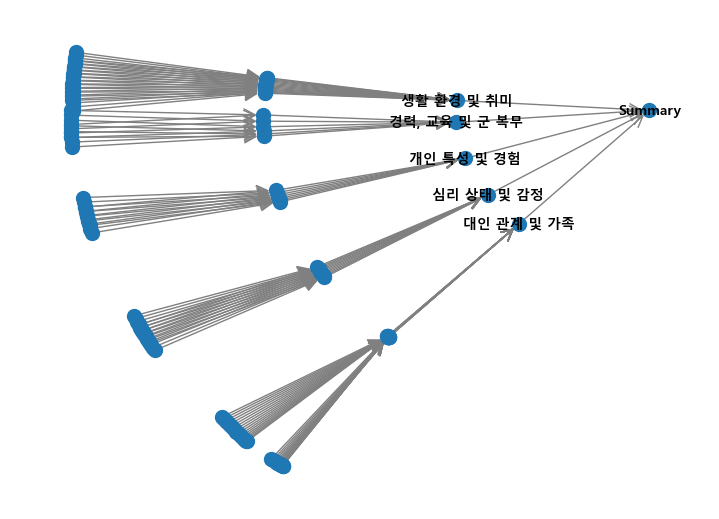

In [11]:
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

graph_list, dict_list = make_graph_2([300], [0], 'sentence-transformers/all-MiniLM-L6-v2')

G = to_networkx(graph_list[0], to_undirected=False)

# 3. 노드 ID(0, 1, 2)에 레이블(A, B, C) 지정
node_labels = {i+1:k
               for i, k in enumerate(dict_list[0].keys())}
node_labels[0] = 'Summary'

# 4. 그래프 시각화
plt.figure(figsize=(7, 5))
pos = nx.kamada_kawai_layout(G) # 노드 위치 결정 알고리즘 (레이아웃)

nx.draw(G, pos,
        with_labels=True,
        labels=node_labels, # A, B, C 레이블 사용
        node_size=100, 
        font_size=10,
        font_weight='bold',
        edge_color='gray',
        arrows=True, # 화살표 표시 (방향성)
        arrowstyle='->',
        arrowsize=20,
        font_family='Malgun Gothic'
       )

## 상호 연결 추가

In [29]:
import os, config as path_config, sys
import pandas as pd
import numpy as np
import torch
from tqdm import tqdm
from torch_geometric.data import Data
from sentence_transformers import SentenceTransformer
from loguru import logger
from sklearn.preprocessing import StandardScaler

logger.remove()
logger.add(
  sys.stdout,
  colorize=True,
  format="<green>{time:HH:mm:ss}</green> | <level>{level: <8}</level> | <level>{message}</level>",
)

model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

In [30]:
def process_vision(df):
  timestamp = df.timestamp
  au_r = df.filter(like='au').filter(like='_r')
  gz_df = df.filter(like='gz')
  gz_h = gz_df.filter(like='h')
  ps_t = df.filter(like='ps').filter(like='T')
  ps_r = df.filter(like='ps').filter(like='R')
  vision = pd.concat([timestamp, au_r, gz_h, ps_t, ps_r], axis=1)
  return vision

def make_graph(ids, labels, model_name):
  try:
    finish_utterance = ["asked everything", "asked_everything", "it was great chatting with you"]

    logger.info("Getting your model")
    model = SentenceTransformer(model_name)
    logger.info("Model loaded")
    dataframes = []
    logger.info("Reading CSV")

    for id in tqdm(ids, desc="Loading Dataframes"):
      df = pd.read_csv(os.path.join(path_config.DATA_DIR, 'Transcription_Topic', f"{id}_transcript_topic.csv"))
      v_df = pd.read_csv(os.path.join(path_config.DATA_DIR, 'Vision Summary', f"{id}_vision_summary.csv"))
      a_df = pd.read_csv(os.path.join(path_config.DATA_DIR, 'Audio Summary', f"{id}_audio_summary.csv"))
      dataframes.append((df, v_df, a_df))
    
    logger.info("Switching CSV into Graphs")
    graphs = []
    dict_list = []
    
    scaler_v = StandardScaler()
    scaler_a = StandardScaler()
    
    for graph_idx, (df, v_df, a_df) in tqdm(enumerate(dataframes), desc="Dataframe -> Graph", total=len(dataframes)):
      try:
        participant_dict = {
          t : []
          for t in df.topic.unique() if type(t)==str
        }
        start_stop_dict = {}

        df.topic = df.topic.ffill()
        df = df.reset_index()
        search_pattern = '|'.join(finish_utterance)
        condition = df['value'].str.contains(search_pattern, na=False)
        terminate_index = df.index[condition]
        df = df.iloc[:terminate_index.values[0]]
        participant_df = df[df.speaker=='Participant']

        # Vision Scaling
        vision = process_vision(v_df)
        vision = vision.fillna(0)
        
        vision_timestamps = vision['timestamp'].values
        vision_features = vision.drop(columns=['timestamp'])
        vision_scaled_np = scaler_v.fit_transform(vision_features)
        vision_scaled_df = pd.DataFrame(vision_scaled_np, columns=vision_features.columns)
        vision_scaled_df['timestamp'] = vision_timestamps

        # Audio Scaling
        a_df = a_df.fillna(0)
        a_scaled_np = scaler_a.fit_transform(a_df)
        a_scaled_df = pd.DataFrame(a_scaled_np, columns=a_df.columns)

        previous_index = None
        previous_topic = None
        temp = ""
        start_time = 0
        stop_time = 0

        for idx, row in participant_df.iterrows():
          value = row['value']
          if pd.isna(value):
            value_str = ""
          else:
            value_str = str(value)

          # 연속 여부 판단
          if previous_index == row['index']-1 and previous_topic==row.topic:
            temp += value_str + ". "
            stop_time = row.stop_time
          else:
            if temp!="" and not pd.isna(previous_topic):
              participant_dict[previous_topic].append(temp)
              start_stop_dict[temp] = [start_time, stop_time]
            previous_topic = row.topic
            temp = value_str
            start_time = row.start_time
            stop_time = row.stop_time

          previous_index = row['index']

        # 마지막 값 저장
        if temp!="" and not pd.isna(previous_topic):
          participant_dict[previous_topic].append(temp)
          start_stop_dict[temp] = [start_time, stop_time]

        # 노드 정의
        s_k_num = len(participant_dict.keys())+1
        source_nodes = np.arange(1, s_k_num)
        target_nodes = np.full(source_nodes.shape, 0)

        # Topic 연결
        if len(participant_dict.keys()) > 1:
          topic_indices = np.arange(1, s_k_num)
          seq_source = topic_indices[:-1] 
          seq_target = topic_indices[1:]
          source_nodes = np.concatenate([source_nodes, seq_source])
          target_nodes = np.concatenate([target_nodes, seq_target])

        topic_nodes = model.encode(list(participant_dict.keys()))
        extra_nodes = None

        node_types = []
        node_types.append('summary')  # 0번 노드
        node_types.extend(['topic'] * len(topic_nodes))  # topic 노드들

        global vision_dim
        global audio_dim
        vision_dim = len(vision.columns)-1 # timestamp 컬럼 제외
        audio_dim = len(a_df.columns)

        text_dim = topic_nodes.shape[1]
        vision_pad_dim = max(0, text_dim - vision_dim)
        audio_pad_dim = max(0, text_dim - audio_dim)
        vision_pad_width = [(0, vision_pad_dim)]
        audio_pad_width = [(0, audio_pad_dim)]

        vision_pad_width = [(0,vision_pad_dim)]
        audio_pad_width = [(0,audio_pad_dim)]

        for idx, v in enumerate(participant_dict.values()):
          if extra_nodes is None:
            start_index = s_k_num
          else:
            start_index = s_k_num + len(extra_nodes)

          transcription_embed = model.encode(v)
          num_utterances = len(transcription_embed)

          # transcription, vision, audio 모두 생성
          t_indices = np.arange(start_index, start_index+num_utterances)

          base_va_index = start_index + num_utterances
          v_indices = base_va_index + np.arange(0, num_utterances * 2, 2)
          a_indices = base_va_index + np.arange(1, num_utterances * 2, 2)

          t_to_topic_source = t_indices
          t_to_topic_target = np.full((num_utterances,), idx + 1)

          v_to_t_source = v_indices
          v_to_t_target = t_indices

          a_to_t_source = a_indices
          a_to_t_target = t_indices

          if num_utterances > 1:
            t_forward_src = t_indices[:-1]
            t_forward_tgt = t_indices[1:]
            t_backward_src = t_indices[1:]
            t_backward_tgt = t_indices[:-1]
          else:
            t_forward_src = t_forward_tgt = t_backward_src = t_backward_tgt = np.array([], dtype=int)
          
          vision_audio_nodes = []

          for sub_idx, t in enumerate(v):

            # Vision
            start, stop = start_stop_dict[t]
            v_target = vision_scaled_df.loc[(start <= vision_scaled_df['timestamp']) & (vision_scaled_df['timestamp'] <= stop)]

            # timestamp 컬럼 제거 후 평균 계산
            if len(v_target) > 0:
              mean_v_target = v_target.drop(columns=['timestamp']).mean().tolist()
            else:
              mean_v_target = np.zeros(vision_dim).tolist()

            if len(mean_v_target) > text_dim: mean_v_target = mean_v_target[:text_dim]
            padded_v = np.pad(mean_v_target, pad_width=vision_pad_width, mode='constant', constant_values=0)
            vision_audio_nodes.append(padded_v)

            # Audio
            start_idx = int(start*100)
            stop_idx = int((stop*100)+1)
            stop_idx = min(stop_idx, len(a_scaled_df))

            a_target = a_scaled_df.iloc[start_idx:stop_idx]
            if len(a_target) > 0:
              mean_a_target = a_target.mean().tolist()
            else:
                mean_a_target = np.zeros(audio_dim).tolist()

            if len(mean_a_target) > text_dim: mean_a_target = mean_a_target[:text_dim]
            padded_a = np.pad(mean_a_target, pad_width=audio_pad_width, mode='constant', constant_values=0)
            vision_audio_nodes.append(padded_a)

          vision_audio_stack=np.stack(vision_audio_nodes)

          if extra_nodes is None:
            extra_nodes = np.concatenate([transcription_embed, vision_audio_stack])
          else:
            extra_nodes = np.concatenate([extra_nodes, transcription_embed, vision_audio_stack])

          node_types.extend(['transcription'] * len(transcription_embed))
          node_types.extend(['vision', 'audio'] * (len(transcription_embed)))

          current_sources = np.concatenate([
              t_to_topic_source, v_to_t_source, a_to_t_source, 
              t_forward_src, t_backward_src
          ])
          current_targets = np.concatenate([
              t_to_topic_target, v_to_t_target, a_to_t_target,
              t_forward_tgt, t_backward_tgt
          ])

          source_nodes = np.concatenate([source_nodes, current_sources])
          target_nodes = np.concatenate([target_nodes, current_targets])

        summary_node = np.average(topic_nodes, axis=0).reshape(1, -1)

        if extra_nodes is None:
          logger.error(f"#{idx} data has empty nodes -> continue to next")
          continue
        else:
          total_nodes = np.concatenate([summary_node, topic_nodes, extra_nodes])

        x = torch.tensor(total_nodes, dtype=torch.float)
        edge_index = torch.tensor([source_nodes, target_nodes], dtype=torch.long)
        y = torch.tensor([labels[graph_idx]], dtype=torch.long)
        data = Data(x=x, edge_index=edge_index, y=y, node_types=node_types)
        graphs.append(data)
        dict_list.append(participant_dict)

      except Exception as e:
        logger.error(f"Index:{graph_idx}: {e}")
        import traceback
        traceback.print_exc()

    return graphs, vision_dim, audio_dim, dict_list
  
  except Exception as e:
    logger.error(e)

In [44]:
graph_list, _, _, dict_list = make_graph([300], [0], 'sentence-transformers/all-MiniLM-L6-v2')

20:32:56 | INFO     | Getting your model
20:32:59 | INFO     | Model loaded
20:32:59 | INFO     | Reading CSV


Loading Dataframes: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]

20:32:59 | INFO     | Switching CSV into Graphs



Dataframe -> Graph: 100%|██████████| 1/1 [00:00<00:00,  5.03it/s]


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_19100\1048105493.py:55: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


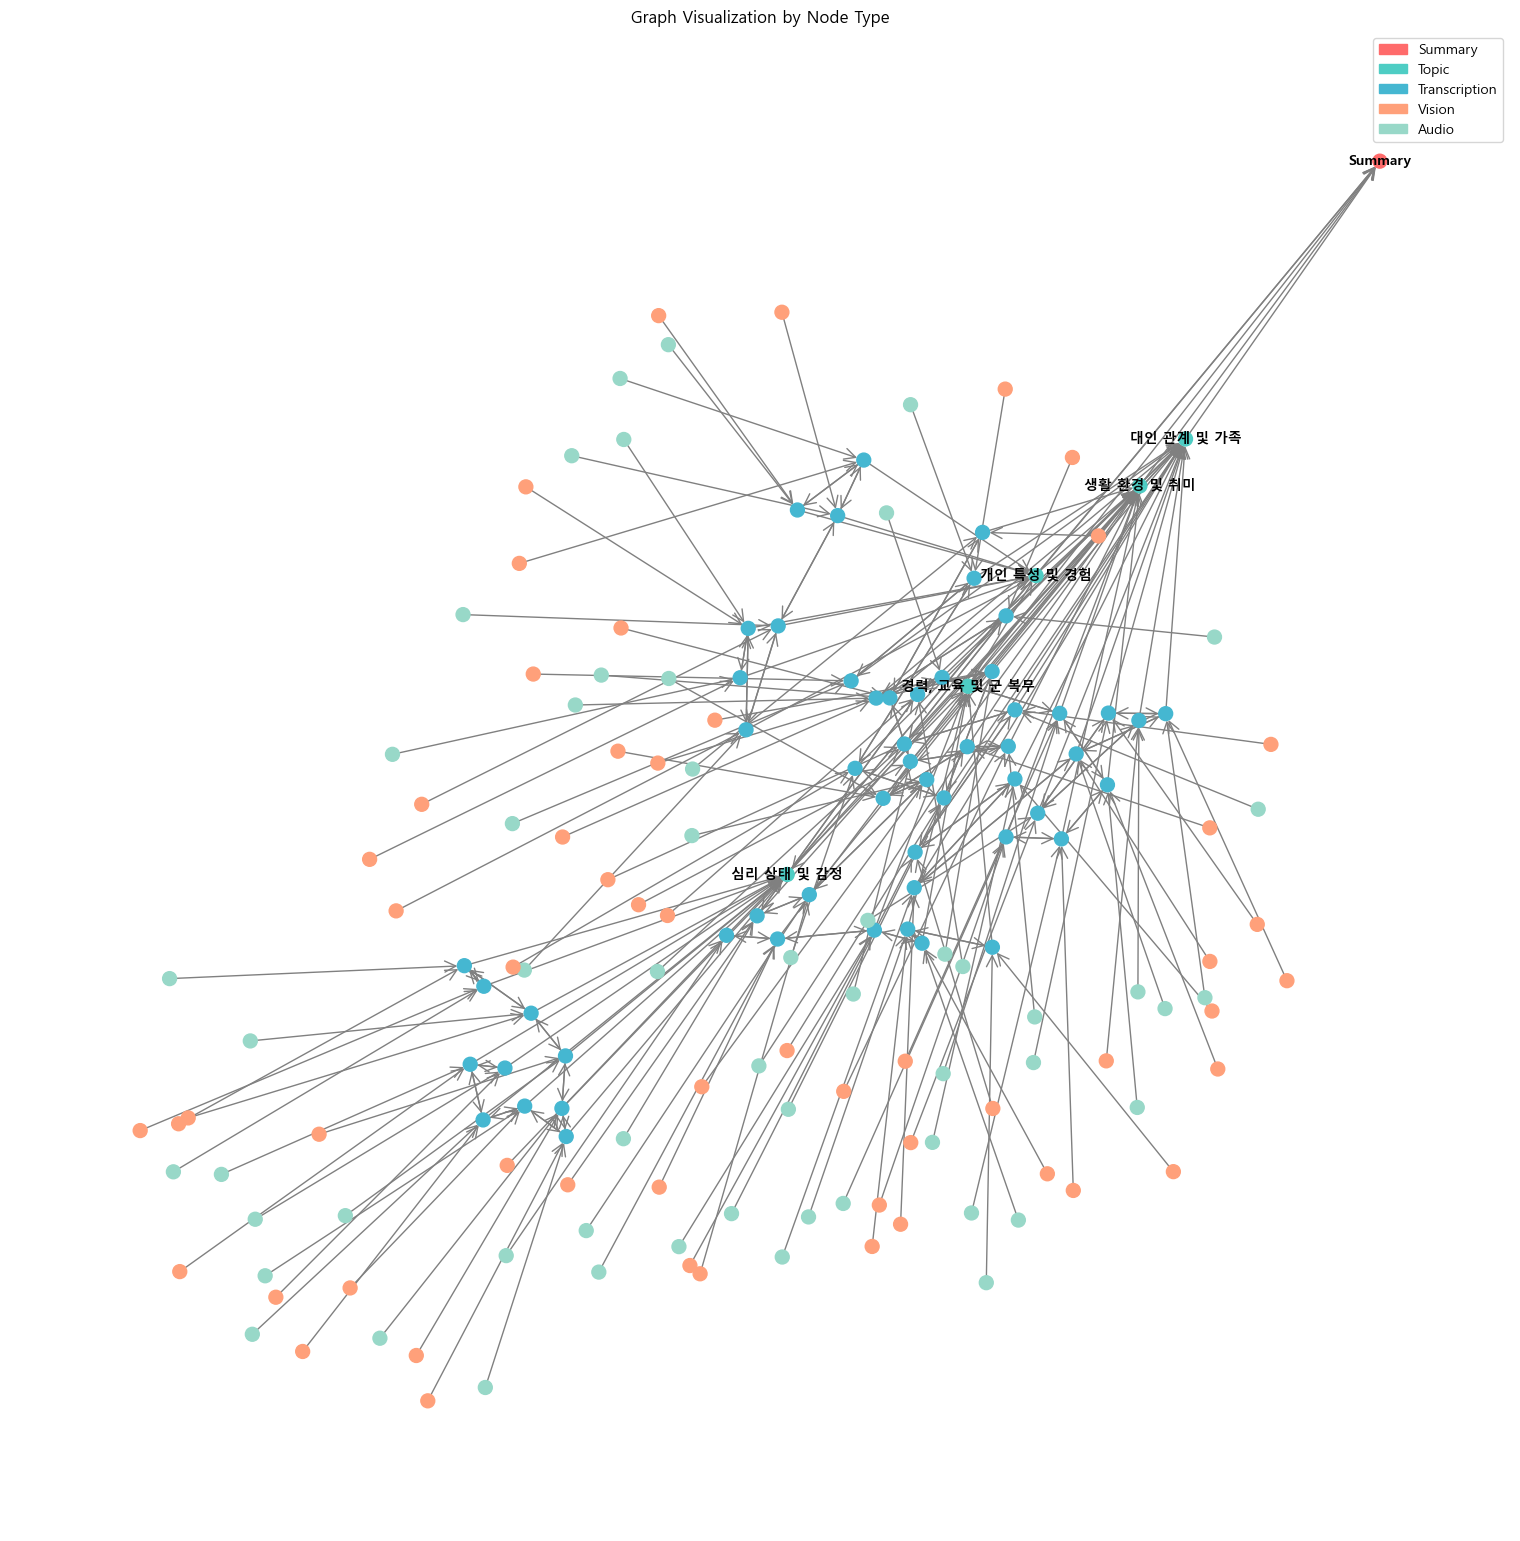

In [45]:
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

color_map = {
    'summary': '#FF6B6B',      # 빨강
    'topic': '#4ECDC4',        # 청록
    'transcription': '#45B7D1', # 파랑
    'vision': '#FFA07A',       # 주황
    'audio': '#98D8C8'         # 민트
}

node_colors = [color_map.get(node_type, 'gray') for node_type in graph_list[0].node_types]

G = to_networkx(graph_list[0], to_undirected=False)

# 3. 노드 ID(0, 1, 2)에 레이블(A, B, C) 지정
node_labels = {i+1:k
               for i, k in enumerate(dict_list[0].keys())}
node_labels[0] = 'Summary'

# 4. 그래프 시각화
plt.figure(figsize=(15, 15))
pos = nx.spring_layout(G) # 노드 위치 결정 알고리즘 (레이아웃)

nx.draw(G, pos,
        with_labels=True,
        labels=node_labels, # A, B, C 레이블 사용
        node_color=node_colors,
        node_size=100, 
        font_size=10,
        font_weight='bold',
        edge_color='gray',
        arrows=True, # 화살표 표시 (방향성)
        arrowstyle='->',
        arrowsize=20,
        font_family='Malgun Gothic',
        
       )

legend_elements = [
    mpatches.Patch(color=color_map['summary'], label='Summary'),
    mpatches.Patch(color=color_map['topic'], label='Topic'),
    mpatches.Patch(color=color_map['transcription'], label='Transcription'),
    mpatches.Patch(color=color_map['vision'], label='Vision'),
    mpatches.Patch(color=color_map['audio'], label='Audio')
]
plt.legend(handles=legend_elements, loc='upper right')

plt.title("Graph Visualization by Node Type")
plt.axis('off')
plt.tight_layout()
plt.show()